In [1]:
from __future__ import absolute_import, division, print_function

%matplotlib inline
# %matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator_tensorflow import get_batch, print_valid_characters
from DataGenerationCommaPlacement import get_batch_comma
from DataGenerationCommaPlacement import num_of_training_samples

import os
import sys
sys.path.append(os.path.join('.', '..')) 
from tempUtils import utils 

import tf_utils

sentence number 6:  77699


In [2]:
# At the bottom of the script there is some code which saves the model.
# If you wish to restore your model from a previous state use this function.
load_model = False

In [3]:
batch_size = 1
#inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
#text_inputs, text_targets_in, text_targets_out = \
#        get_batch(batch_size=batch_size, max_digits=10, min_digits=5)

inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_targets_in, text_targets_out = \
        get_batch_comma(batch_size=batch_size, indices_of_interest = [0])
    
    
print(inputs.shape)
print("input types:", inputs.dtype)#, inputs_seqlen.dtype, targets_in.dtype, targets_out.dtype, targets_seqlen.dtype)

for i in range(batch_size):
    print("\nSAMPLE",i)
    print("ENCODED INPUTS:\t\t\t", inputs[i])
    print("INPUTS SEQUENCE LENGTH:\t\t", inputs_seqlen[i])
    print("TEXT TARGETS OUTPUT:\t\t", text_targets_out[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])
    print("ENCODED TARGETS OUTPUT:\t\t", targets_out[i])
    print("ENCODED TARGETS INPUT:\t\t", targets_in[i])
    print("TARGETS SEQUENCE LENGTH:\t", targets_seqlen[i])
    print("TARGETS MASK:\t\t\t", targets_mask[i])

(1, 13)
input types: int32

SAMPLE 0
ENCODED INPUTS:			 [48887 51435 51435 74718 74718 74718 37710 37710 40510 40510 40510 40510
 47685]
INPUTS SEQUENCE LENGTH:		 13
TEXT TARGETS OUTPUT:		 6#
TEXT TARGETS INPUT:		 #48887 51435 51435 74718 74718 74718 99060 37710 37710 40510 40510 40510 40510 47685 
ENCODED TARGETS OUTPUT:		 [ 6 20  0  0  0  0  0  0  0  0  0  0  0]
ENCODED TARGETS INPUT:		 [48887 51435 51435 74718 74718 74718 37710 37710 40510 40510 40510 40510
 47685]
TARGETS SEQUENCE LENGTH:	 13
TARGETS MASK:			 [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


### Encoder-Decoder model setup
Below is the TensorFlow model definition. We use an embedding layer to go from integer representation to vector representation of the input.

TensorFlow has implementations of LSTM and GRU units.
Both implementations assume that the input from the tensor below has the shape **`[batch_size, max_time, input_size]`**, (unless you have `time_major=True`, in which case it is `[max_time, batch_size, input_size]`).

Note that we have made use of a custom decoder wrapper which can be found in `tf_utils.py`.

In [12]:
# resetting the graph
tf.reset_default_graph()

# Setting up hyperparameters and general configs
NUM_INPUTS = 125002
NUM_OUTPUTS = 21 #(0-19 + '#'+",")

BATCH_SIZE = 100
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 256
NUM_UNITS_DEC = 256


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')


### Building the model
# first we build the embeddings to make our characters into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_INPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')


## forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below incase TF's makes issues
# enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
# enc_state = tf.concat(1, [enc_state, enc_state])

## decoding
# note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
# check out tf_utils to see how you make your own decoder

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

dec_out, valid_dec_out = tf_utils.decoder(enc_state, t_embedded, t_len, 
                                          NUM_UNITS_DEC, t_embeddings,
                                          W_out, b_out)

## reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
valid_out_tensor = tf.reshape(valid_dec_out, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
valid_out_tensor = tf.matmul(valid_out_tensor, W_out) + b_out

## reshaping back to sequence
# print('X_len', tf.shape(X_len)[0])
b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable we know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat([tf.expand_dims(b_size, 0),
                      tf.expand_dims(seq_len, 0),
                      tf.expand_dims(num_out, 0)],
                     axis=0)

out_tensor = tf.reshape(out_tensor, out_shape)
valid_out_tensor = tf.reshape(valid_out_tensor, out_shape)
# handling shape loss
#out_tensor.set_shape([None, None, NUM_OUTPUTS])
y = out_tensor
y_valid = valid_out_tensor

In [6]:
# print all the variable names and shapes
for var in tf.global_variables ():
    s = var.name + " "*(40-len(var.name))
    print(s, var.value().get_shape())

X_embeddings:0                           (125002, 8)
t_embeddings:0                           (125002, 8)
rnn/gru_cell/gates/kernel:0              (40, 64)
rnn/gru_cell/gates/bias:0                (64,)
rnn/gru_cell/candidate/kernel:0          (40, 32)
rnn/gru_cell/candidate/bias:0            (32,)
W_out:0                                  (32, 21)
b_out:0                                  (21,)
decoder/W_z_x:0                          (8, 32)
decoder/W_z_h:0                          (32, 32)
decoder/b_z:0                            (32,)
decoder/W_r_x:0                          (8, 32)
decoder/W_r_h:0                          (32, 32)
decoder/b_r:0                            (32,)
decoder/W_c_x:0                          (8, 32)
decoder/W_c_h:0                          (32, 32)
decoder/b_h:0                            (32,)


### Defining the cost function, gradient clipping and accuracy
Because the targets are categorical we use the cross entropy error.
As the data is sequential we use the sequence to sequence cross entropy supplied in `tf_utils.py`.
We use the Adam optimizer but you can experiment with the different optimizers implemented in [TensorFlow](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer).

In [13]:
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!

    ## if you want regularization
    #reg_scale = 0.00001
    #regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #reg_term = sum([regularize(param) for param in params])
    #loss += reg_term
    
    ## calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)

# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)

## add below for clipping by norm
# gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
# clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
# grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [17]:
# print all the variable names and shapes
# notice that we now have the optimizer Adam as well!
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    #print(s, var.value().get_shape())

Instructions for updating:
Please use tf.global_variables instead.


### Testing the forward pass

In [14]:
## Start the session
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.35)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts, inter_op_parallelism_threads=4,
                   intra_op_parallelism_threads=4))

# Initialize parameters
if load_model:
    try:
        tf.train.Saver().restore(sess, "/tmp/model1.ckpt")
    except:
        sess.run(tf.global_variables_initializer())
        print('Model not found, new parameters initialized')
else:
    sess.run(tf.global_variables_initializer())

In [15]:
# as always, test the forward pass and initialize the tf.Session!
for i in range(batch_size):
    print("\nSAMPLE",i)
   # print("TEXT INPUTS:\t\t\t", text_inputs[i])
    print("TEXT TARGETS INPUT:\t\t", text_targets_in[i])

feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}

# test training forwardpass
fetches = [y, X_embedded, enc_state]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("inputs", inputs)
print("input length", inputs_seqlen)
print("encoder state", res[2].shape)
print("targets output", targets_out)

print("y", res[0].shape)
print("X_embedded", res[1].shape)

# test validation forwardpass
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print("y_valid", res[0].shape)


SAMPLE 0
TEXT TARGETS INPUT:		 #48887 51435 51435 74718 74718 74718 99060 37710 37710 40510 40510 40510 40510 47685 
inputs [[48887 51435 51435 74718 74718 74718 37710 37710 40510 40510 40510 40510
  47685]]
input length [13]
encoder state (1, 256)
targets output [[ 6 20  0  0  0  0  0  0  0  0  0  0  0]]
y (1, 13, 21)
X_embedded (1, 13, 8)
y_valid (1, 13, 21)


# Training

Training RNN can take a while, especially if you are running it on your laptop.
We won't train the model to completion, as the trends we are interested in can be seen earlier.
If training takes to long feel free to stop it even earlier by interrupting the kernel.

In [18]:
num_epochs = 5
num_of_training_samples_loaded = num_of_training_samples()
num_of_samples_for_validation = 100
num_of_training_samples_minus_validation = num_of_training_samples_loaded - num_of_samples_for_validation
num_batches_train = int(num_of_training_samples_minus_validation / BATCH_SIZE)
print(num_batches_train)

775


In [19]:
#Generate some validation data
validation_indices = list(range(num_of_training_samples_minus_validation, num_of_training_samples_minus_validation+num_of_samples_for_validation))
print(len(validation_indices))
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_targets_in_val, text_targets_out_val = \
    get_batch_comma(batch_size=num_of_samples_for_validation, indices_of_interest = validation_indices)
print("X_val", X_val.shape)
print("t_out_val", t_out_val.shape)

100
X_val (100, 17)
t_out_val (100, 17)


Done
Wall time: 26min 5s


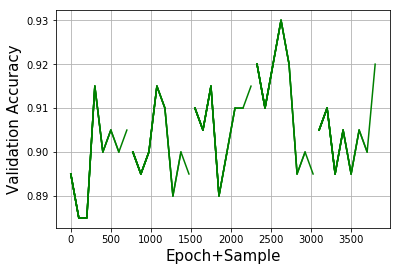

In [21]:
%%time
## If you get an error, remove this line! It makes the error message hard to understand.

# setting up running parameters
val_interval = 100

samples_val = []
costs, accs_val = [], []
plt.figure()
batch_number = 0
try:
    for epoch in range(num_epochs):
        epoch_batches = []
        accs_val = []
        print("Epoch: ", epoch)
        for i in range(num_batches_train): 
            # load data
            #print("Epoch {0} new Batch: {1} ".format(epoch, i))
            
            #Select random part of the training data   
            idxs = np.random.choice(range(num_of_training_samples_minus_validation), size=(BATCH_SIZE), replace=False)
            X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
            text_targets_in_tr, text_targets_out_tr = \
                get_batch_comma(batch_size=BATCH_SIZE, indices_of_interest = idxs)
            # make fetches
            fetches_tr = [train_op, loss, accuracy]
            # set up feed dict
            feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
                 ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
            # run the model
            res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
            _, batch_cost, batch_acc = res
            costs += [batch_cost]
            
            #if samples_processed % 1000 == 0: print(batch_cost, batch_acc)
            #validation data
            if i % val_interval == 0:
                print("validating")
                fetches_val = [accuracy_valid, y_valid]
                feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
                 ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
                res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
                
                acc_val, output_val = res
                
                accs_val += [acc_val]
                epoch_batches +=[epoch*num_batches_train+i]
                print("val: ", epoch_batches)
                print("accs_val: ", accs_val)
                plt.plot(epoch_batches, accs_val, 'g-')
                plt.ylabel('Validation Accuracy', fontsize=15)
                plt.xlabel('Epoch+Sample', fontsize=15)
                plt.title('', fontsize=20)
                plt.grid('on')
                plt.savefig("out.png")
                display.display(display.Image(filename="out.png"))
                display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

print('Done')

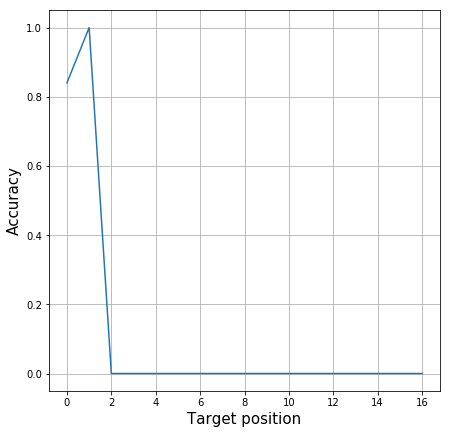

In [22]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?

In [23]:
## Save model
# Read more about saving and loading models at https://www.tensorflow.org/programmers_guide/saved_model

# Save model
save_path = tf.train.Saver().save(sess, "/tmp/model1.ckpt")
print("Model saved in file: %s" % save_path)


Model saved in file: /tmp/model1.ckpt


In [24]:
X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
         text_targets_in_tr, text_targets_out_tr = \
            get_batch_comma(batch_size=1,indices_of_interest = [180])
# make fetches
fetches_tr = [train_op, loss, accuracy, y]
# set up feed dict
feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
# run the model
res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
#print("input", text_inputs_tr)
print("input", text_targets_in_tr)
print("y: ", np.argmax(res[3],axis = 2))



input ['#94380 60929 60929 95339 95339 99060 70498 47820 63246 63246 60638 47685 ']
y:  [[ 5 20 20 20 20 20 20 20 20 20 20]]


In [17]:
## Close the session, and free the resources
sess.close()

# Exercises:


### Exercise 1)
1. What is the final validation performance? 
1. Why do you think it is not better?
1. Comment on the accuracy for each position in of the output symbols?

___
Answer:
1. 0.65
1. probably because the training were cut short. I tried running it for 2e6 iterations instead, which resulted in an accuracy of approximately 0.9
1. The accuracy of the first symbol is clearly the highest, after that the accuracy drops slightly for the ensuing symbols, and then starts to sharply plummet. This is probably because an error in the first symbols will affect the prediction for the next symbols, and make it even harder to do a correct prediction. 


### Exercise 2)
The model has two GRU networks. The ```GRUEncoder``` and the ```GRUDecoder```.
A GRU is parameterized by a update gate $u$, a  reset gate $r$, the cell $c$, and the hidden state $h$:

![](images/GRUeq.png)
*Equations as described in the [Lasagne GRU documentation](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer).*

**Note** that the notation in the implementation (`tf_utils.py`) $z$ is used instead of $u$.

Under normal circumstances, such as in the TensorFlow GRUCell implementation, these gates have been stacked for faster computation, but in the custom decoder each weight and bias are as described in the original [article for GRU](https://arxiv.org/abs/1406.1078).
 1. Try to explain the shape of $W_{xr}$ and $W_{hr}$.
 1. Why are they different? 

___
Answer: [Suggested Answer]
1. (1a) Lets look at $W_{xr}$: r determines the number of parameters the r gate contains. x is the size of the input vector. Thus the matrix $W_{xr}$ contains the weights for all the transitions between the input and the parameters in the r gate. So the final shape will be (number_of_input_parameters, number_of_parameters_in_r_gate).
1. (1b) Now let us look at $W_{hr}$: h determines the size of the *state*, the number of parameters in the hidden state. r has the same meaning as before. This means that the matrix $W_{hr}$ will contain the weights for all the transitions from the prior hidden state to the parameters in the read gate. Thus the shape will be: (number_of_input_parameters, number_of_parameters_in_r_gate)
1. In a GRU cell the external input at time t, doesn't have to have the same size as the hidden state (and hence the prior state). Thus it is necessary that x and h can vary in size, and hence also the weight matrices be different.


### Exercise 3)
The GRU-unit is able to ignore the input and just copy the previous hidden state.
In the beginning of training this might be desireable behaviour because it helps the model learn long range dependencies.
You can make the model ignore the input by modifying initial bias values.
1. What bias would you modify and how would you modify it?

Again you'll need to refer to the [GRU equations](http://lasagne.readthedocs.io/en/latest/modules/layers/recurrent.html#lasagne.layers.GRULayer)
Further, if you look into `tf_utils.py` and search for the `decoder(...)` function, you will see that the init for each weight and bias can be changed.

___
Answer:
In order for the model to ignore the input, and just copy the previous hidden state, we would have to make $u_t$ be $0$ as this would make the model ignore any internally proposed updates to the state, and just copy the previous state as per the definition of $h_t$. 

The only value that directly affects the value of $u_t$ is $b_u$ which could be set to $-\infty$ or a very high negative value. In the case the activation function should squash it, so that $u_t$ will be $0$, at least if the sigmoid activation function is used for $u_t$. Which it is in the provided model.

### Exercise 4)
In the example we stack a softmax layer on top of a Recurrent layer. In the code snippet below explain how we can do that?
___
Answer:
In order to use softmax to provide us with class probabilities for the output of a single GRU unit (i.e. batch size = 1 and sequence length = 1), we will need a fully connected layer using softmax activation, between the output nodes of the GRU cell and the output classes. 
The Tensorflow API for constructing such a layer is $[batch\_size, num\_of\_params]$, and if the rank of the input is greater, then it will be flattened automatically before doing the matrix multiplication. 
Since we have a batch of 16, where each have 140 GRU unit outputs (of 10 output nodes each), we need to combine these two into one batch, in order to use the tensorflow API.

This is possible and doesn't change our predictions as the classfication happens *after* the recurrent layer. At this point the $140$ GRU outputs in each sequence are *independent* of each other, and thus they might be thought of, as a batch of $140 \cdot 16$ GRU cell outputs. 


In [18]:
tf.reset_default_graph()

bs_, seqlen_, numinputs_ = 16, 140, 40 # Batch_size, Sequence_length, number_of_inputs
x_pl_ = tf.placeholder(tf.float32, [bs_, seqlen_, numinputs_])
gru_cell_ = tf.nn.rnn_cell.GRUCell(10)
l_gru_, gru_state_ = tf.nn.dynamic_rnn(gru_cell_, x_pl_, dtype=tf.float32)
l_reshape_ = tf.reshape(l_gru_, [-1, 10])

l_softmax_ = tf.contrib.layers.fully_connected(l_reshape_, 11, activation_fn=tf.nn.softmax)
l_softmax_seq_ = tf.reshape(l_softmax_, [bs_, seqlen_, -1])

print("l_input_\t", x_pl_.get_shape())
print("l_gru_\t\t", l_gru_.get_shape())
print("gru_state\t", gru_state_.get_shape())
print("l_reshape_\t", l_reshape_.get_shape())
print("l_softmax_\t", l_softmax_.get_shape())
print("l_softmax_seq_\t", l_softmax_seq_.get_shape())

l_input_	 (16, 140, 40)
l_gru_		 (16, 140, 10)
gru_state	 (16, 10)
l_reshape_	 (2240, 10)
l_softmax_	 (2240, 11)
l_softmax_seq_	 (16, 140, 11)


### Optional Exercise 1)
Why do you think the validation performance looks more "jig-saw" like compared to FFN and CNN models?

___
Answer:

### Optional Exercise 2)
You are interested in doing sentiment analysis on tweets, i.e classification as positive or negative. You decide read over the twitter seqeuence and use the last hidden state to do the classification. How can you modify the small network above to only output a single classification for network? Hints: look at the gru\_state\_ or the [tf.slice](https://www.tensorflow.org/versions/r0.10/api_docs/python/array_ops.html#slice) in the API.




### Optional Exercise 3)
Bidirectional Encoders are usually implemented by running a forward model and  a backward model (a forward model on a reversed sequence) separately and the concatenating them before parsing them on to the next layer. To reverse the sequence try looking at [tf.reverse_sequence](https://www.tensorflow.org/versions/r0.10/api_docs/python/array_ops.html#reverse_sequence)

Implement a Bidirectional encoder model.
Here is some code to get you started:

``` python
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32, scope="rnn_forward")
X_embedded_backwards = tf.reverse_sequence(X_embedded, tf.to_int64(X_len), 1)
enc_cell_backwards = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)
_, enc_state_backwards = tf.nn.dynamic_rnn(cell=enc_cell_backwards, inputs=X_embedded_backwards,
                                 sequence_length=X_len, dtype=tf.float32, scope="rnn_backward")

enc_state = tf.concat(1, [enc_state, enc_state_backwards])
```

Note: you will need to double the NUM_UNITS_DEC, as it currently does not support different sizes.

Book Question:

I am answering the question regarding what is the advantage of online learning compared to normal stochastic gradient descent learning with larger mini batch sizes (like 20):

There are two main differences:
1. The quality of the gradient updates. The batch gradient averaged over the batch has a larger likelihood of approximating the true gradient for the whole training set than the one for online learning. Hence the quality of the gradient in batch training is supposedly higher. 
1. The number of weight updates. In batch training the weights are updated once per batch, while in online learning the weights are updated after each sample has been looked at.

Based on the above, we can see that in general the online learning version will tend to "jump" a bit more, compared to the normal mini batch version,around in the solution space, this has both advantages and disadvantaged based on the expected solution space.

If the solution space contains many deep local minima's (i.e. minima's that are very difficult to escape from) Online learning might be a good choice, because it will be more likely to escape from such a minima. On the other hand if there are multiple local minima's but there are not too deep and the space in general is more smooth, it would be more feasible to use the mini batch of 20 version, as this would both be able to escape the local minimas and also "in general" take the faster route towards the global minima.